In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

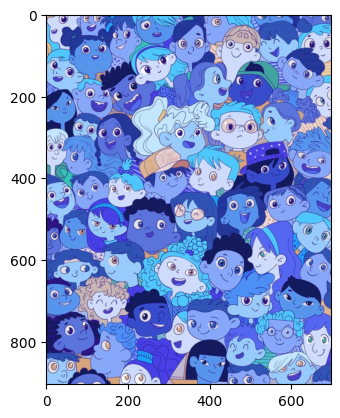

In [27]:
image = cv2.imread(r'F:\study\project\AIT3005-Midterm\1\1.jpg')
plt.imshow(image)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [ ]:
object_list = [
    r"F:\study\project\AIT3005-Midterm\image\ice_cream.jpg",
    r"F:\study\project\AIT3005-Midterm\image\boat.png",
    r"F:\study\project\AIT3005-Midterm\image\balloon.png",
    r"F:\study\project\AIT3005-Midterm\image\car.png",
    r"F:\study\project\AIT3005-Midterm\image\pony.png",
    r"F:\study\project\AIT3005-Midterm\image\watermelon.png",
    r"F:\study\project\AIT3005-Midterm\image\train.png",
    r"F:\study\project\AIT3005-Midterm\image\cake.png",
    r"F:\study\project\AIT3005-Midterm\image\duck.png",
    r"F:\study\project\AIT3005-Midterm\image\grapes.png",
    r"F:\study\project\AIT3005-Midterm\image\rabbit.png",
    r"F:\study\project\AIT3005-Midterm\image\strawberry.png",
    r"F:\study\project\AIT3005-Midterm\image\teddy_bear.png",
    r"F:\study\project\AIT3005-Midterm\image\tennis_ball.png",
    r"F:\study\project\AIT3005-Midterm\image\tie.png",
]

In [29]:
output_image = image.copy()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(113, 90), dtype=uint8)

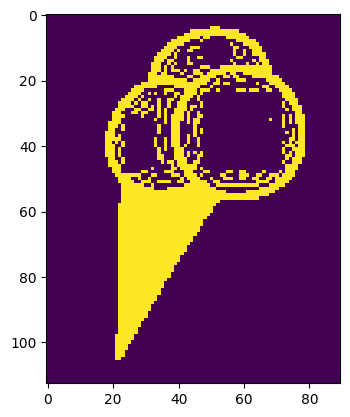

In [30]:
# mask background
def create_mask(template):
    gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray_template, 200, 255, cv2.THRESH_BINARY_INV)
    plt.imshow(mask)
    return mask

create_mask(cv2.imread(object_list[0]))

In [ ]:
# iou function (calculate overlapping ratio)
def iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_p, y1_p, x2_p, y2_p = box2
    
    xi1, yi1 = max(x1, x1_p), max(y1, y1_p)
    xi2, yi2 = min(x2, x2_p), min(y2, y2_p)
    
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_p - x1_p) * (y2_p - y1_p)
    
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

# non maximum suppression (remove overlapping bounding box)
def non_maximum_suppression(boxes, scores, iou_threshold=0.5):
    indices = np.argsort(scores)[::-1]
    keep_boxes = []

    while len(indices) > 0:
        best_idx = indices[0]
        keep_boxes.append(boxes[best_idx])

        new_indices = []
        for i in range(1, len(indices)):
            if iou(boxes[best_idx], boxes[indices[i]]) < iou_threshold:
                new_indices.append(indices[i])
        
        indices = np.array(new_indices)

    return keep_boxes

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [01:28<00:00,  5.91s/it]


5


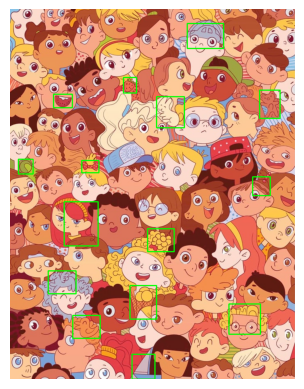

In [32]:
# scale the size of template (from 50% -> 100%, step = 10)
scales = np.linspace(0.5, 1, 10)

# threshold
threshold = 0.52

output_image = image.copy()

count = 0

for object_path in tqdm(object_list):
    file_name = os.path.basename(object_path)
    name = os.path.splitext(file_name)[0]
    # print(name)

    template = cv2.imread(object_path)
    mask = create_mask(template)

    def run_template_matching(input_image, template, mask, return_best_only=False):
        best_match = None
        candidates = []
        for scale in scales:
            resized_template = cv2.resize(template, (0, 0), fx=scale, fy=scale)
            resized_mask = cv2.resize(mask, (resized_template.shape[1], resized_template.shape[0]))

            w, h = resized_template.shape[1], resized_template.shape[0]

            result = cv2.matchTemplate(input_image, resized_template, cv2.TM_CCOEFF_NORMED, mask=resized_mask)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

            if max_val > threshold:
                candidates.append((max_val, max_loc, (max_loc[0] + w, max_loc[1] + h)))

            if best_match is None or max_val > best_match[0]:
                best_match = (max_val, max_loc, (max_loc[0] + w, max_loc[1] + h))

        return best_match if return_best_only else candidates

    # template_matching with initial image
    candidates = run_template_matching(image, template, mask)

    # using canny edge detection if there are more than 1 bounding box
    if len(candidates) != 1:
        canny_template = cv2.Canny(template, 50, 150)
        _, canny_mask = cv2.threshold(canny_template, 200, 255, cv2.THRESH_BINARY_INV)
        canny_image = cv2.Canny(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), 100, 200)
        best_match = run_template_matching(canny_image, canny_template, canny_mask, return_best_only=True)
        count += 1
    else:
        best_match = candidates[0] if candidates else None

    if best_match:
        _, (x1, y1), (x2, y2) = best_match
        cv2.rectangle(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

print(count)

plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()